In [406]:
import numpy as np
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (13, 13)

# Kalman
x_n = a * x_n-1 + noise

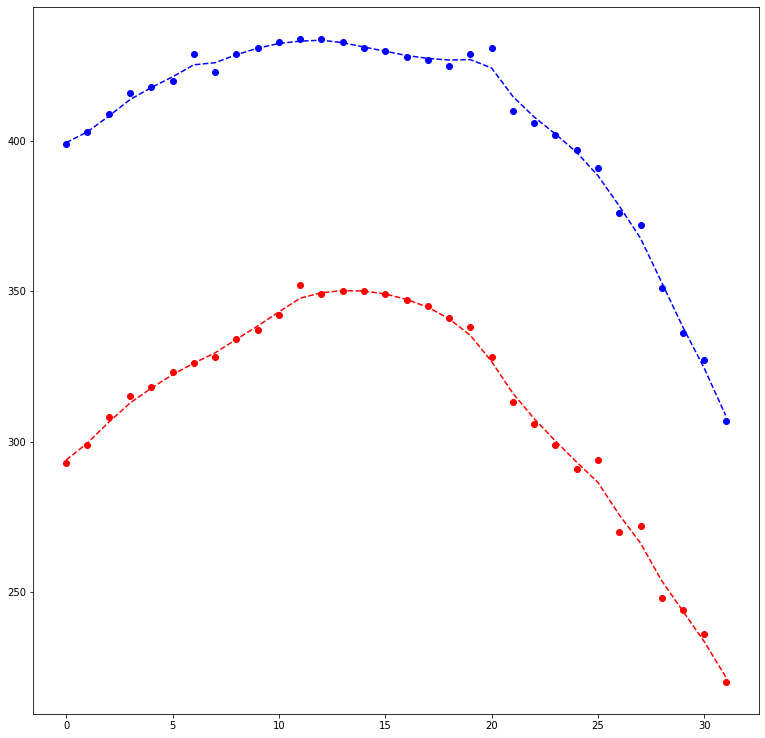

In [407]:
from pykalman import KalmanFilter
import time

measurements = np.asarray([(399,293),(403,299),(409,308),(416,315),(418,318),(420,323),(429,326),(423,328),(429,334),(431,337),(433,342),(434,352),(434,349),(433,350),(431,350),(430,349),(428,347),(427,345),(425,341),(429,338),(431,328),(410,313),(406,306),(402,299),(397,291),(391,294),(376,270),(372,272),(351,248),(336,244),(327,236),(307,220)])

initial_state_mean = [measurements[0, 0],
                      0,
                      measurements[0, 1],
                      0]

transition_matrix = [[1, 1, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 1],
                     [0, 0, 0, 1]]

observation_matrix = [[1, 0, 0, 0],
                      [0, 0, 1, 0]]

kf1 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean)

kf1 = kf1.em(measurements, n_iter=5)
(smoothed_state_means, smoothed_state_covariances) = kf1.smooth(measurements)

plt.figure(1)
times = range(measurements.shape[0])
plt.plot(times, measurements[:, 0], 'bo',
         times, measurements[:, 1], 'ro',
         times, smoothed_state_means[:, 0], 'b--',
         times, smoothed_state_means[:, 2], 'r--',)
plt.show()

# An attempt at creating a Particle Filter

In [616]:
import numpy as np
import scipy

class ParticleFilter:
    def __init__(self, N, ranges, step_function, eval_function, plot_particles_function, resampling_algo):
        self.N = N
        self.ranges = ranges
        self.particles = self.uniform_particles(ranges, N)
        self.weights = np.ones(N) / N
        self.ranges = ranges
        
        self.step_function = step_function
        self.eval_function = eval_function
        self.plot_particles_function = plot_particles_function
        self.resampling_algo = resampling_algo
    
    def uniform_particles(self, ranges, N):
        # Returns list of uniform particles
        particles = np.empty((N, len(ranges)))
        for i, (start, end) in enumerate(ranges):
            particles[:, i] = np.random.uniform(start, end, size=N)
        return particles
    
    def predict(self):
        # step :: particles -> new_particles
        # self.particles = np.array([self.step_function(particle) for particle in self.particles])
        self.particles = self.step_function(self.particles)
    
    def update(self, measurement, sensor_std_err):
        distances = np.linalg.norm(self.particles[:, 0:2] - measurement, axis=1)
        self.weights *= scipy.stats.norm(distances, sensor_std_err).pdf(0)
        
        self.weights += 1.e-100 # avoid round off to zero
        self.weights /= sum(self.weights) # normalize
    
    def estimate(self):
        # evaluate :: particle -> result
        results = np.array([self.eval_function(particle) for particle in self.particles])
        mean = np.average(results, weights=self.weights, axis=0)
        var = np.average((results - mean)**2, weights=self.weights, axis=0)
        return mean, var
    
    def resample(self):
        self.particles, self.weights = self.resampling_algo(self.particles, self.weights)
    
    def neff(self):
        return 1. / np.sum(np.square(self.weights))
    
    def plot2D(self):
        plt.scatter(x=self.particles[:, 0], y=self.particles[:, 1], c='b')
        
        mean, var = self.estimate()
        plt.scatter(x=mean[0], y=mean[1], s=80, facecolors='none', edgecolors='b')

        plt.xlim(self.ranges[0])
        plt.ylim(self.ranges[1])
        
        from matplotlib.patches import Ellipse
        
        e = Ellipse(xy=mean, height=var[1], width=var[0])
        ax = plt.gca()  # ax = subplot( 1,1,1 )
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        e.set_edgecolor("red")
        e.set_facecolor("none")  # "none" not None
        e.set_alpha(1)
        
    def plotSimulation(self, start_particle, steps):
        evolution = np.array([start_particle])
        for _ in range(steps):
            new_particle = self.step_function(np.array([evolution[-1]]))[0]
            evolution = np.concatenate((evolution, [new_particle]), axis=0)
        self.plot_particles_function(evolution)

#### Particle = tuple(x, y, heading)
#### Predict = move 1 unit in the heading direction
#### Plot_particle = get x and y coordinates
#### Evaluate = distance from measurement squared

In [617]:
def step(particles):
    N = len(particles)
    particles[:, 0] += particles[:, 2] + np.random.randn(N) * 1
    particles[:, 1] += particles[:, 2] + np.random.randn(N) * 1
    return particles

def evaluate(particle):
    return particle

def plot_particles(particles):
    xs = particles[:, 0]
    ys = particles[:, 1]
    plt.plot(xs, ys, 'bo', markersize=5)
    
def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, np.random.uniform(0, 1, N))
    
    return particles[indexes], np.ones(N)/N

# Testing

In [618]:
start_point = np.array([100., 0., 3.])
steps = 30

measurements = [start_point]
for _ in range(steps):
    new_point = step(np.array([measurements[-1]]))[0]
    measurements = np.concatenate((measurements, [new_point]), axis=0)
measurements = measurements[:, 0:2]
    
measurements += np.random.normal(0, 1, (steps + 1, 2))

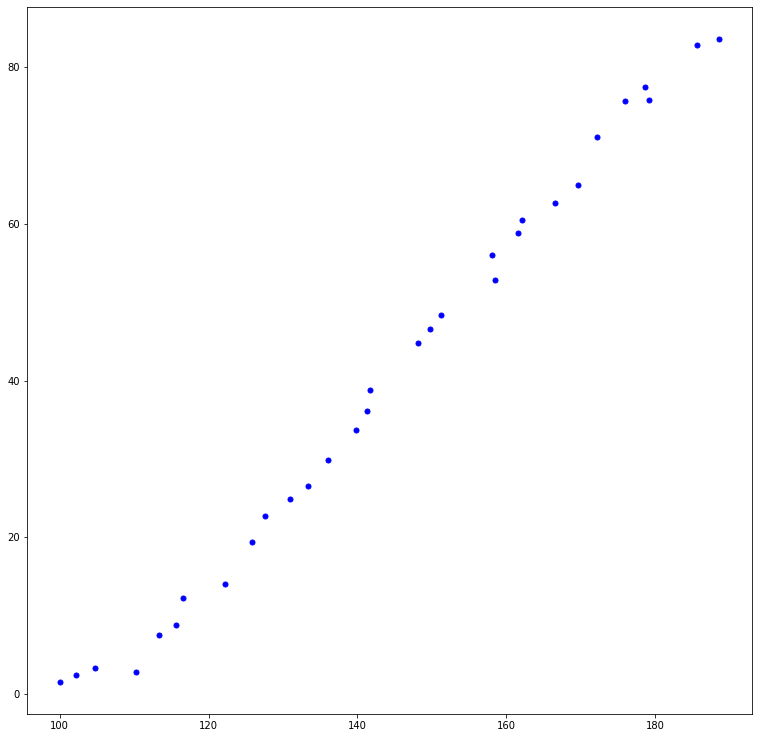

In [619]:
plot_particles(measurements)

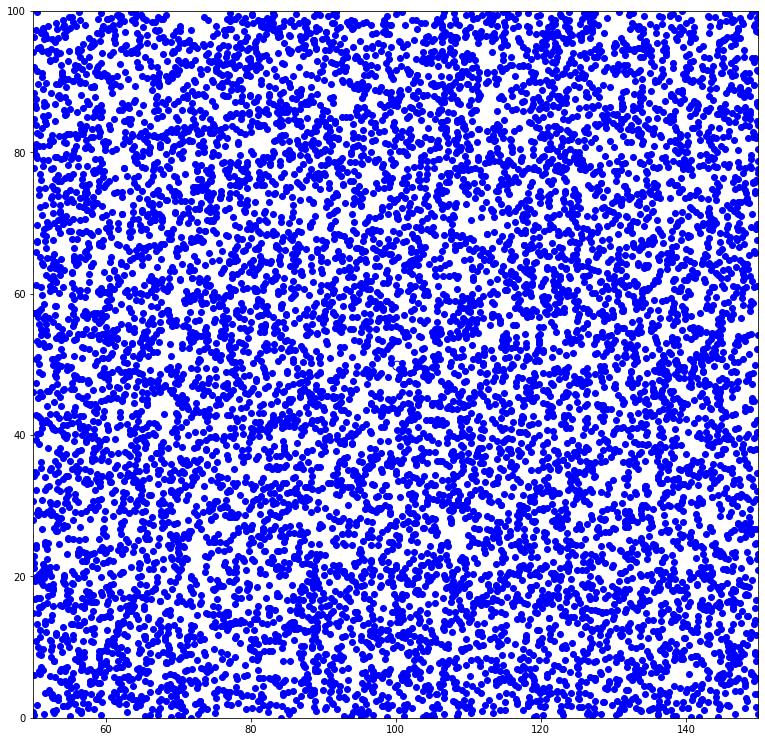

In [620]:
pf = ParticleFilter(
    N=10000, 
    ranges=[(50, 150), (0, 100), (0, 2*np.pi)],
    step_function=step,
    eval_function=evaluate,
    plot_particles_function=plot_particles,
    resampling_algo=simple_resample
)

i = 0
pf.plot2D()
def pf_step():
    global i
    if i == steps:
        print("FINISHED")
    else:
        i += 1
        pf.predict()
        pf.update(measurement=measurements[i], sensor_std_err=5)
    
        if pf.neff() < len(pf.particles)/2:
            print("Resampling at time ", i)
            pf.resample()
    pf.plot2D()

Resampling at time  1
Resampling at time  3
Resampling at time  5
Resampling at time  8
Resampling at time  10
Resampling at time  13
Resampling at time  16
Resampling at time  19
Resampling at time  23
Resampling at time  28


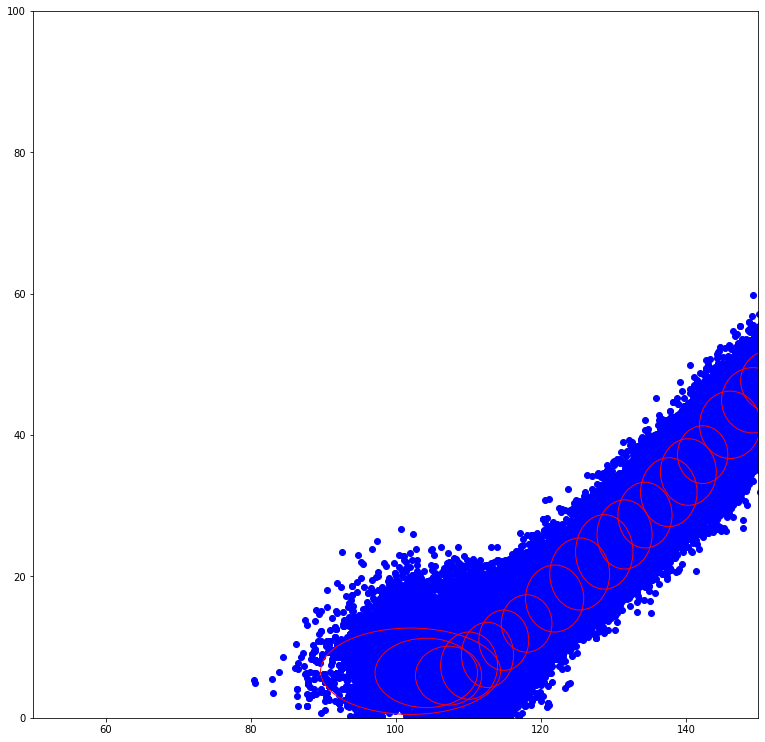

In [621]:
means, variances = [], []
for _ in range(steps):
    pf_step()
    mean, var = pf.estimate()
    means.append(mean)
    variances.append(var)

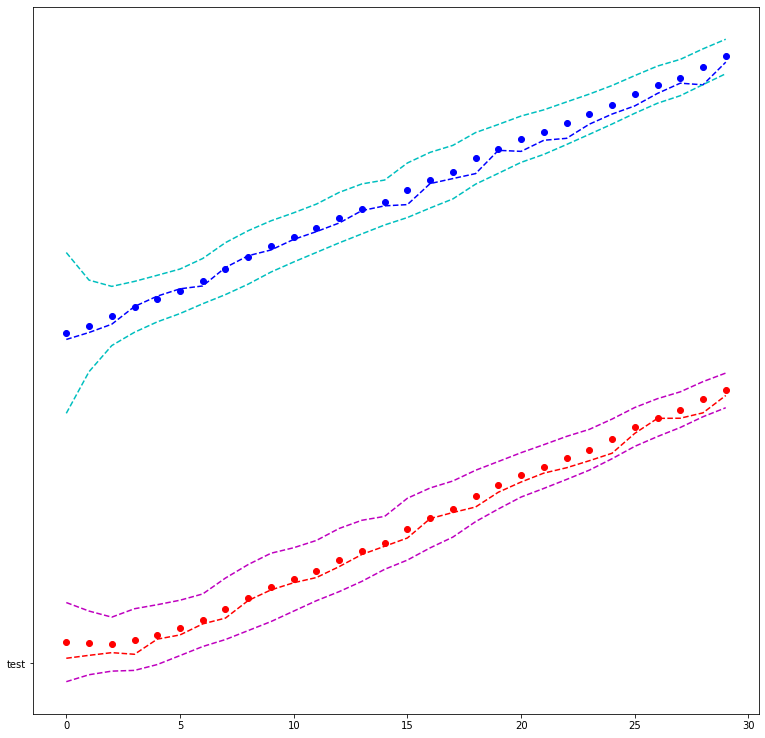

In [622]:
means = np.array(means)
variances = np.array(variances)

top = means + variances
bot = means - variances


plt.plot(range(steps), means[:, 0], 'bo',
         range(steps), measurements[:-1, 0], 'b--',
         range(steps), top[:, 0], 'c--',
         range(steps), bot[:, 0], 'c--',
         
         range(steps), means[:, 1], 'ro',
         range(steps), measurements[:-1, 1], 'r--',
         range(steps), top[:, 1], 'm--',
         range(steps), bot[:, 1], 'm--', "test"
)